**Автор: Анна Смелова**

## Решение домашнего задания к уроку 4 "Алгоритм построения дерева решений"

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Задание 1
Используя файл Lesson_4_extended.ipynb (он в web4.zip в материалах):
#### В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

**Критерии останова** - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. (max_tree_depth_stop)


- Ограничение максимального количества листьев. (max_leaf_num_stop)


- Ограничение минимального количества $n$ объектов в листе. (min_leaf_object_stop)


- Останов в случае, когда все объекты в листе относятся к одному классу. (single_class_stop)

In [2]:
# ИЗМЕНЕНИЯ: добавила классов для наглядности
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=2000, n_features=2, n_informative=2, 
                                                                 n_classes=4, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=9)

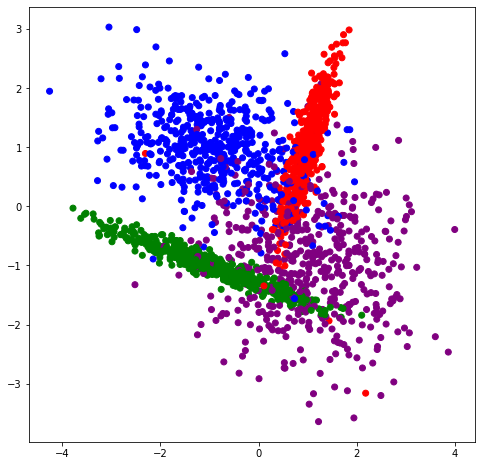

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['green', 'blue', 'purple', 'red'])
light_colors = ListedColormap(['lightgreen', 'lightblue', 'violet', 'lightcoral'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Критерий Джини: $H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2}$

Прирост: $H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r})$

In [6]:
# ИЗМЕНЕНИЯ: дерево организуем тоже классом
# Класс дерева

class Tree:
    
    # ИЗМЕНЕНИЯ: здесь указаны параметры для останова
    def __init__(self, max_tree_depth_stop=100, max_leaf_num_stop=100, min_leaf_object_stop=1, single_class_stop=False):
        self.max_depth = max_tree_depth_stop
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num_stop
        self.min_objects = min_leaf_object_stop
        self.single_class = single_class_stop
        self.tree = None
        
    # Расчет критерия Джини
    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_gini):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return root_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
    # Разбиение датасета в узле
    def split(self, data, labels, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_gini = self.gini(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_gini)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels):

        gain, t, index = self.find_best_split(data, labels)
        
        # ИЗМЕНЕНИЯ: здесь добавила базовые случаи для остановки построения дерева
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth >= self.max_depth:
            #print('Base2')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            #print('Base3')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            #print('Base4')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 5 - прекращаем рекурсию, когда все объекты в листе относятся к одному классу
        if  self.single_class and len(set(labels)) == 1:
            #print('Base5')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
         #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            #print('Base1')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [7]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [8]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [9]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [10]:
# Построим несколько деревьев с разными критериями останова по обучающей выборке 
tree_1 = Tree() # без критерия
tree_1.fit(train_data, train_labels)

tree_2 = Tree(max_tree_depth_stop=5) # ограничим глубину дерева
tree_2.fit(train_data, train_labels)

tree_3 = Tree(max_leaf_num_stop=20) # ограничим количество листьев
tree_3.fit(train_data, train_labels)

tree_4 = Tree(min_leaf_object_stop=50) # ограничим количество объектов в листе
tree_4.fit(train_data, train_labels)

tree_5 = Tree(single_class_stop=True) # остановка, если один класс в листе
tree_5.fit(train_data, train_labels)

In [11]:
print('Без ограничений(остановы по умолчанию)\n')
print(f'Глубина:{tree_1.depth},листьев:{len(tree_1.leaves)},один класс в листе:{tree_1.single_class}\n')
print_tree(tree_1.tree)

Без ограничений(остановы по умолчанию)

Глубина:99,листьев:100,один класс в листе:False

Индекс 1 <= -0.11531819016496903
--> True:
  Индекс 0 <= -0.04045839178741528
  --> True:
    Индекс 1 <= -1.5191032201140318
    --> True:
      Прогноз: 2
    --> False:
      Индекс 1 <= -0.40633621721837576
      --> True:
        Индекс 0 <= -0.45838237211026545
        --> True:
          Индекс 0 <= -1.6448733212870983
          --> True:
            Индекс 1 <= -0.8288046196415754
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0 <= -1.9421539972744715
              --> True:
                Прогноз: 0
              --> False:
                Индекс 0 <= -1.7757402217381706
                --> True:
                  Прогноз: 0
                --> False:
                  Прогноз: 0
          --> False:
            Индекс 1 <= -0.6552592216295086
            --> True:
              Индекс 1 <= -0.7422659204940638
              --> True:
           

In [12]:
print('Максимальная глубина: 5\n')
print(f'Глубина:{tree_2.depth},листьев:{len(tree_2.leaves)},один класс в листе:{tree_2.single_class}\n')
print_tree(tree_2.tree)

Максимальная глубина: 5

Глубина:5,листьев:6,один класс в листе:False

Индекс 1 <= -0.11531819016496903
--> True:
  Индекс 0 <= -0.04045839178741528
  --> True:
    Индекс 1 <= -1.5191032201140318
    --> True:
      Прогноз: 2
    --> False:
      Индекс 1 <= -0.40633621721837576
      --> True:
        Индекс 0 <= -0.45838237211026545
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Прогноз: 2
--> False:
  Прогноз: 3


In [13]:
print('количество листьев: 20\n')
print(f'Глубина:{tree_3.depth},листьев:{len(tree_3.leaves)},один класс в листе:{tree_3.single_class}\n')
print_tree(tree_3.tree)

количество листьев: 20

Глубина:19,листьев:20,один класс в листе:False

Индекс 1 <= -0.11531819016496903
--> True:
  Индекс 0 <= -0.04045839178741528
  --> True:
    Индекс 1 <= -1.5191032201140318
    --> True:
      Прогноз: 2
    --> False:
      Индекс 1 <= -0.40633621721837576
      --> True:
        Индекс 0 <= -0.45838237211026545
        --> True:
          Индекс 0 <= -1.6448733212870983
          --> True:
            Индекс 1 <= -0.8288046196415754
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0 <= -1.9421539972744715
              --> True:
                Прогноз: 0
              --> False:
                Индекс 0 <= -1.7757402217381706
                --> True:
                  Прогноз: 0
                --> False:
                  Прогноз: 0
          --> False:
            Индекс 1 <= -0.6552592216295086
            --> True:
              Индекс 1 <= -0.7422659204940638
              --> True:
                Индекс 0 <= 

In [14]:
print('Количество объектов в листе: 50\n')
print(f'Глубина:{tree_4.depth},листьев:{len(tree_4.leaves)},один класс в листе:{tree_4.single_class}\n')
print_tree(tree_4.tree)

Количество объектов в листе: 50

Глубина:48,листьев:49,один класс в листе:False

Индекс 1 <= -0.11531819016496903
--> True:
  Индекс 0 <= -0.04045839178741528
  --> True:
    Индекс 1 <= -1.5191032201140318
    --> True:
      Прогноз: 2
    --> False:
      Индекс 1 <= -0.40633621721837576
      --> True:
        Индекс 0 <= -0.45838237211026545
        --> True:
          Индекс 0 <= -1.6448733212870983
          --> True:
            Индекс 1 <= -0.8288046196415754
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0 <= -1.9421539972744715
              --> True:
                Прогноз: 0
              --> False:
                Прогноз: 0
          --> False:
            Индекс 1 <= -0.6552592216295086
            --> True:
              Индекс 1 <= -0.7422659204940638
              --> True:
                Индекс 0 <= -1.5765385407574115
                --> True:
                  Прогноз: 0
                --> False:
                  Инд

In [15]:
print('Остановка, если один класс в листе\n')
print(f'Глубина:{tree_5.depth},листьев:{len(tree_5.leaves)},один класс в листе:{tree_5.single_class}\n')
print_tree(tree_5.tree)

Остановка, если один класс в листе

Глубина:99,листьев:100,один класс в листе:True

Индекс 1 <= -0.11531819016496903
--> True:
  Индекс 0 <= -0.04045839178741528
  --> True:
    Индекс 1 <= -1.5191032201140318
    --> True:
      Прогноз: 2
    --> False:
      Индекс 1 <= -0.40633621721837576
      --> True:
        Индекс 0 <= -0.45838237211026545
        --> True:
          Индекс 0 <= -1.6448733212870983
          --> True:
            Индекс 1 <= -0.8288046196415754
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0 <= -1.9421539972744715
              --> True:
                Прогноз: 0
              --> False:
                Индекс 0 <= -1.7757402217381706
                --> True:
                  Прогноз: 0
                --> False:
                  Прогноз: 0
          --> False:
            Индекс 1 <= -0.6552592216295086
            --> True:
              Индекс 1 <= -0.7422659204940638
              --> True:
                

In [16]:
# Получим ответы для обучающей выборки 
train_answers_1 = tree_1.predict(train_data)
train_answers_2 = tree_2.predict(train_data)
train_answers_3 = tree_3.predict(train_data)
train_answers_4 = tree_4.predict(train_data)
train_answers_5 = tree_5.predict(train_data)
# И получим ответы для тестовой выборки
answers_1 = tree_1.predict(test_data)
answers_2 = tree_2.predict(test_data)
answers_3 = tree_3.predict(test_data)
answers_4 = tree_4.predict(test_data)
answers_5 = tree_5.predict(test_data)

In [17]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
print(train_accuracy_1)
train_accuracy_2 = accuracy_metric(train_labels, train_answers_2)
print(train_accuracy_2)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
print(train_accuracy_3)
train_accuracy_4 = accuracy_metric(train_labels, train_answers_4)
print(train_accuracy_4)
train_accuracy_5 = accuracy_metric(train_labels, train_answers_5)
print(train_accuracy_5)

91.71428571428571
62.57142857142857
62.642857142857146
88.28571428571429
91.71428571428571


In [18]:
# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, answers_1)
print(test_accuracy_1)
test_accuracy_2 = accuracy_metric(test_labels, answers_2)
print(test_accuracy_2)
test_accuracy_3 = accuracy_metric(test_labels, answers_3)
print(test_accuracy_3)
test_accuracy_4 = accuracy_metric(test_labels, answers_4)
print(test_accuracy_4)
test_accuracy_5 = accuracy_metric(test_labels, answers_5)
print(test_accuracy_5)

84.66666666666667
60.16666666666667
60.333333333333336
85.83333333333333
84.66666666666667


In [19]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, tree, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

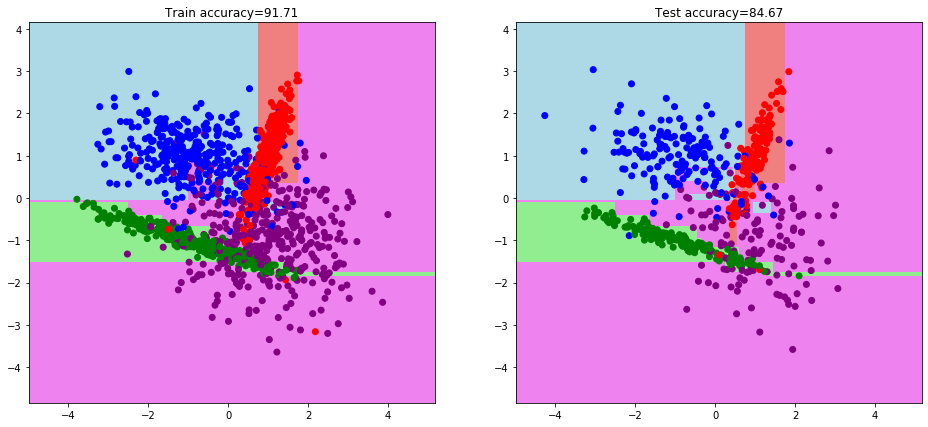

In [20]:
# без критерия (заметно переобучение)
visualize(train_data, test_data, tree_1, train_accuracy_1, test_accuracy_1)

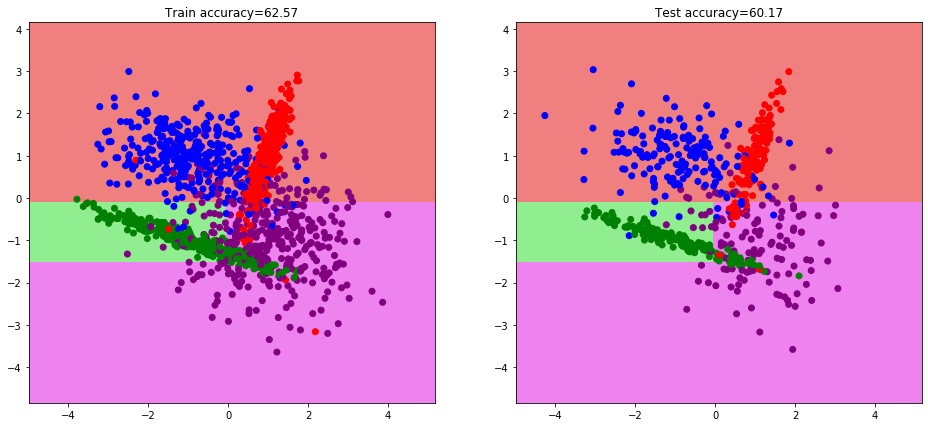

In [21]:
# ограничение на глубину дерева (5)
visualize(train_data, test_data, tree_2, train_accuracy_2, test_accuracy_2)

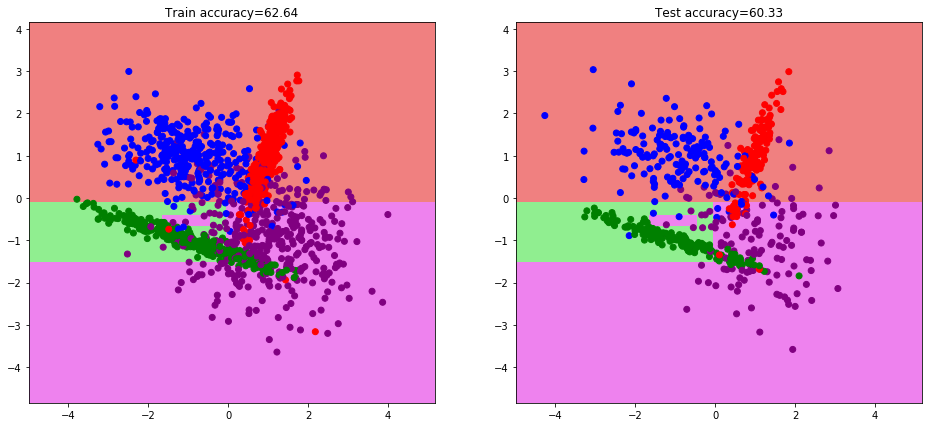

In [22]:
# ограничение на количество листьев (20)
visualize(train_data, test_data, tree_3, train_accuracy_3, test_accuracy_3)

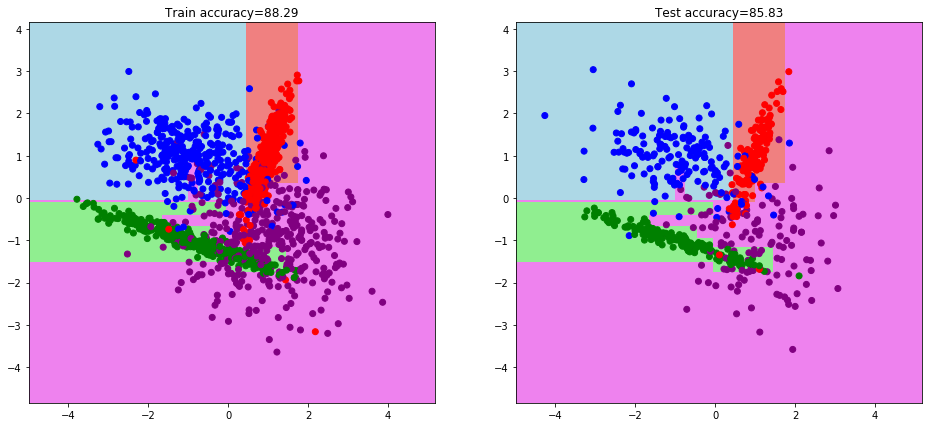

In [23]:
# ограничение на количество объектов в листе (50)
visualize(train_data, test_data, tree_4, train_accuracy_4, test_accuracy_4)

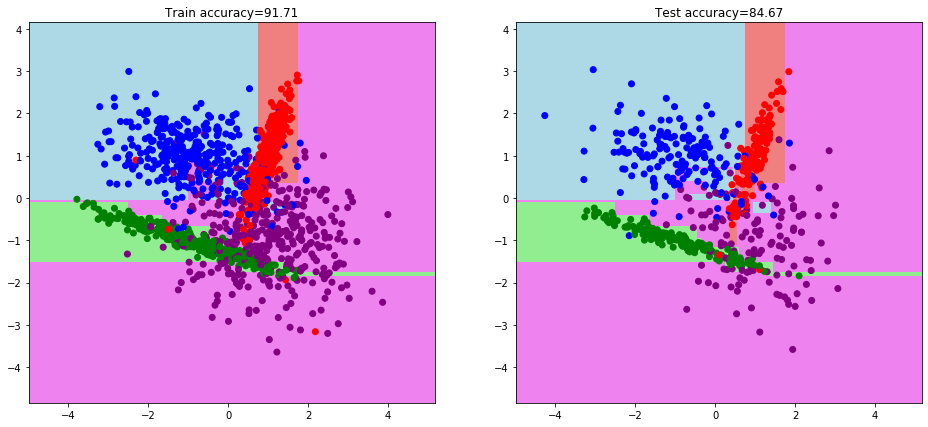

In [24]:
# остановка, если один класс в листе
visualize(train_data, test_data, tree_5, train_accuracy_5, test_accuracy_5)

**Вывод:** Видно, что разные критерии останова влияют на качество классификации. Понятно, что, чтобы добиться наилучшего качества и избежать переобучения модели, необходимо подбирать данные параметры останова.<br>
С последним критерием (остановка, если один класс в листе) получилось, что нет разницы с моделью вообще без критериев останова. Может быть это связано с тем, что данные критерий имеет смысл при несбалансированности классов (это только мое предположение, не проверяла).

### Задание 2*
Используя файл Lesson_4_extended.ipynb (он в web4.zip в материалах):
#### Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [25]:
# сгенерируем линейный набор данных с 2 признаками с шумом
X1, Y1 = make_regression(n_samples=100, n_features=2, n_informative=2, n_targets=1, 
                                      noise=7, coef=False, random_state=9)

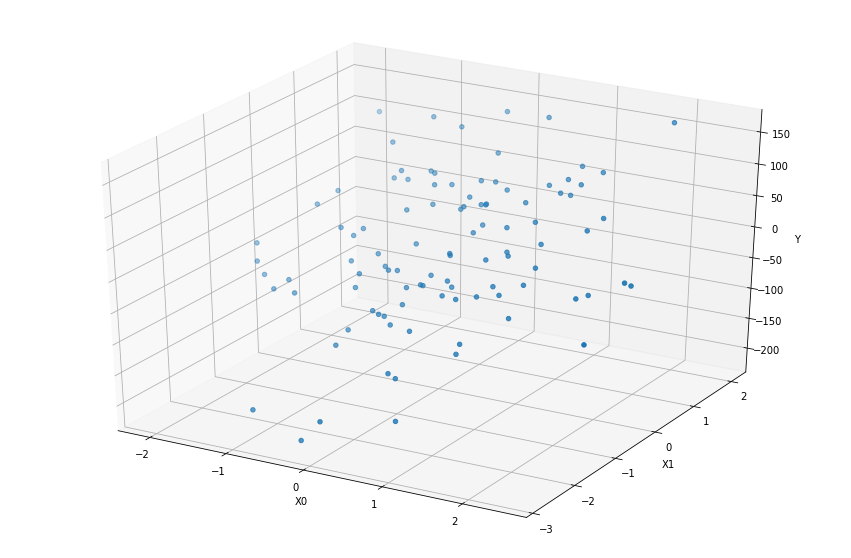

In [26]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1[:, 0], X1[:, 1], Y1)

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Y')
plt.show()

In [27]:
# и нелинейный с 1 признаком с шумом
X2 = np.linspace(0,5,500)
Y2 = np.sin(X2)**2+np.exp(-X2**2) + np.random.normal(0, 0.1, 500)

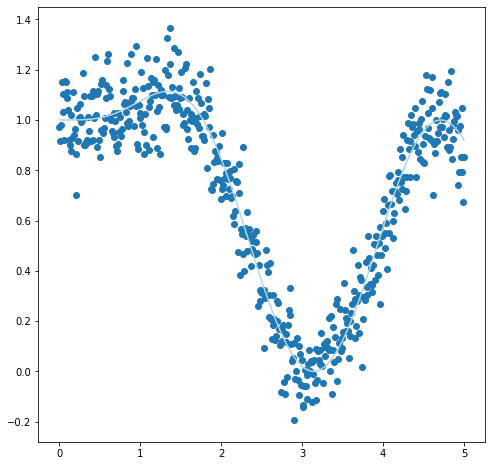

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(X2, Y2)
plt.plot(X2, np.sin(X2)**2+np.exp(-X2**2),c='lightBlue')
plt.show()

In [29]:
X2 = X2.reshape((500, 1))

In [30]:
# Реализуем класс узла

class Node_r:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [31]:
# И класс терминального узла (листа)

class Leaf_r:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    # ИЗМЕНЕНИЯ: здесь заменила предсказание на среднее значение по листу    
    def predict(self):    
        prediction = np.mean(labels)
        return prediction       

In [32]:
# ИЗМЕНЕНИЯ: здесь тоже дерево классом
# Класс дерева

class Tree_r:
    
    def __init__(self, max_tree_depth_stop=100, max_leaf_num_stop=100, min_leaf_object_stop=1):
        self.max_depth = max_tree_depth_stop
        self.nodes = []
        self.leaves = []
        self.depth = 0
        self.max_leaves = max_leaf_num_stop
        self.min_objects = min_leaf_object_stop
        self.tree = None
        
    
    # ИЗМЕНЕНИЯ:вместо критерия Джини расчет среднеквадратичного отклонения
    def mse(self, labels):
        mean = labels.mean()
        return np.mean((labels - mean)**2)
    
    # Расчет прироста
    def gain(self, left_labels, right_labels, root_mse):

        # доля выборки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        
        gain = root_mse - p * self.mse(left_labels) - (1 - p) * self.mse(right_labels)
        if gain > 0:
            return gain
        else:
            return 0

    
    
    # Разбиение датасета в узле

    def split(self, data, labels, column_index, t):

        left = np.where(data[:, column_index] <= t)
        right = np.where(data[:, column_index] > t)

        true_data = data[left]
        false_data = data[right]

        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):

        #  обозначим минимальное количество объектов в узле
        min_samples_leaf = 5

        root_mse = self.mse(labels)

        best_gain = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                    continue

                current_gain = self.gain(true_labels, false_labels, root_mse)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_gain > best_gain:
                    best_gain, best_t, best_index = current_gain, t, index

        return best_gain, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels):

        gain, t, index = self.find_best_split(data, labels)
 
        #  Базовый случай 2 - прекращаем рекурсию, когда достигли максимальной глубины дерева
        if self.depth >= self.max_depth:
            #print('Base2')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 3 - прекращаем рекурсию, когда достигли максимального количества листьев
        if len(self.leaves) >= self.max_leaves - 1 or self.depth >= self.max_leaves - 1:
            #print('Base3')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 4 - прекращаем рекурсию, когда достигли минимального количества объектов в листе
        if len(data) <= self.min_objects:
            #print('Base4')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)
        
        #  Базовый случай 1 - прекращаем рекурсию, когда нет прироста в качества
        if gain == 0:
            #print('Base1')
            self.leaves.append(Leaf(data, labels))
            return Leaf(data, labels)

        self.depth += 1
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        self.nodes.append(Node(index, t, true_branch, false_branch))
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)
    
    def fit(self, data, labels):
        self.tree = self.build_tree(data, labels)
        return self
    
    def predict(self, data):
    
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.tree)
            classes.append(prediction)
        return classes

In [33]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data_1, test_data_1, train_labels_1, test_labels_1 = train_test_split(X1, 
                                                                    Y1, 
                                                                    test_size=0.3,
                                                                    random_state=1)

train_data_2, test_data_2, train_labels_2, test_labels_2 = train_test_split(X2, 
                                                                    Y2, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [34]:
tree_r_1 = Tree_r() 
tree_r_1.fit(train_data_1, train_labels_1)

tree_r_2 = Tree_r() 
tree_r_2.fit(train_data_2, train_labels_2)

In [35]:
print(f'Глубина:{tree_r_1.depth},листьев:{len(tree_r_1.leaves)}\n')
print_tree(tree_r_1.tree)

Глубина:10,листьев:11

Индекс 1 <= -0.2799097428503502
--> True:
  Индекс 1 <= -1.3256234310025483
  --> True:
    Прогноз: -184.12792496453804
  --> False:
    Индекс 1 <= -0.7986616075918641
    --> True:
      Индекс 1 <= -1.0905774859695576
      --> True:
        Прогноз: -86.65637186286276
      --> False:
        Прогноз: -58.90357975506044
    --> False:
      Индекс 1 <= -0.4999026196066131
      --> True:
        Прогноз: -43.059547747086285
      --> False:
        Прогноз: -28.45102695676329
--> False:
  Индекс 1 <= 0.16299855722993525
  --> True:
    Индекс 1 <= -0.08258774062153114
    --> True:
      Прогноз: -1.9302381346055846
    --> False:
      Прогноз: 3.219022733911253
  --> False:
    Индекс 1 <= 1.023033487768843
    --> True:
      Индекс 1 <= 0.6752711674321854
      --> True:
        Прогноз: 34.316380194202964
      --> False:
        Индекс 1 <= 0.8352808611135286
        --> True:
          Прогноз: 51.22212303569526
        --> False:
          Прогноз: 6

In [36]:
print(f'Глубина:{tree_r_2.depth},листьев:{len(tree_r_2.leaves)}\n')
print_tree(tree_r_2.tree)

Глубина:53,листьев:54

Индекс 0 <= 2.1543086172344688
--> True:
  Индекс 0 <= 1.8637274549098195
  --> True:
    Индекс 0 <= 0.7715430861723447
    --> True:
      Индекс 0 <= 0.1002004008016032
      --> True:
        Прогноз: 1.0860114100429108
      --> False:
        Индекс 0 <= 0.21042084168336672
        --> True:
          Прогноз: 0.9000704379416713
        --> False:
          Индекс 0 <= 0.6412825651302605
          --> True:
            Индекс 0 <= 0.561122244488978
            --> True:
              Индекс 0 <= 0.4308617234468938
              --> True:
                Индекс 0 <= 0.3006012024048096
                --> True:
                  Прогноз: 0.9927493003954435
                --> False:
                  Прогноз: 0.9160994864547916
              --> False:
                Индекс 0 <= 0.5110220440881763
                --> True:
                  Прогноз: 0.9588647829448798
                --> False:
                  Прогноз: 1.1593485662039873
            --> Fa

In [37]:
# Считаем ошибку
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [38]:
# Получим ответы для обучающей выборки 
train_answers_r_1 = tree_r_1.predict(train_data_1)
train_answers_r_2 = tree_r_2.predict(train_data_2)
# И получим ответы для тестовой выборки
answers_r_1 = tree_r_1.predict(test_data_1)
answers_r_2 = tree_r_2.predict(test_data_2)

In [39]:
# Ошибка на обучающей выборке
train_accuracy_r_1 = calc_mse(train_labels_1, train_answers_r_1)
print(train_accuracy_r_1)
# Ошибка на тестовой выборке
test_accuracy_r_1 = calc_mse(test_labels_1, answers_r_1)
print(test_accuracy_r_1)
print()
# Ошибка на обучающей выборке
train_accuracy_r_2 = calc_mse(train_labels_2, train_answers_r_2)
print(train_accuracy_r_2)
# Ошибка на тестовой выборке
test_accuracy_r_2 = calc_mse(test_labels_2, answers_r_2)
print(test_accuracy_r_2)

207.52057736836258
895.9058261746283

0.011844931585030069
0.0197470697473308


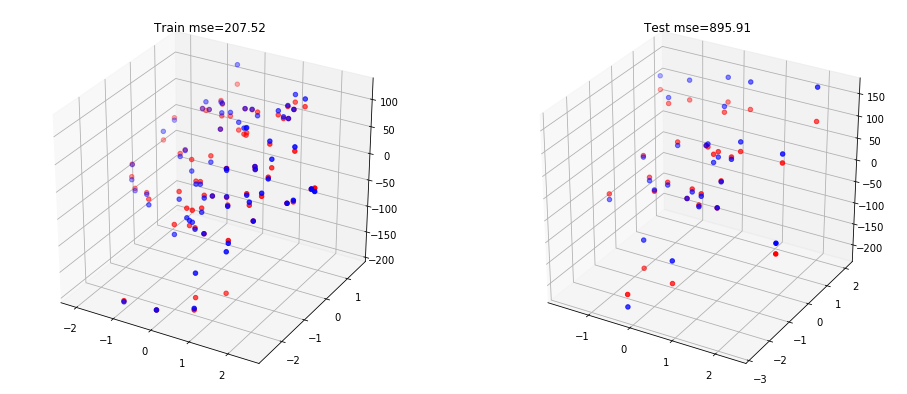

In [40]:
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(train_data_1[:, 0], train_data_1[:, 1], train_labels_1, c='b')
ax1.scatter(train_data_1[:, 0], train_data_1[:, 1], train_answers_r_1, c='r')
ax1.set_title(f'Train mse={train_accuracy_r_1:.2f}')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(test_data_1[:, 0], test_data_1[:, 1], test_labels_1, c='b')
ax2.scatter(test_data_1[:, 0], test_data_1[:, 1], answers_r_1, c='r')
ax2.set_title(f'Test mse={test_accuracy_r_1:.2f}')

plt.show()

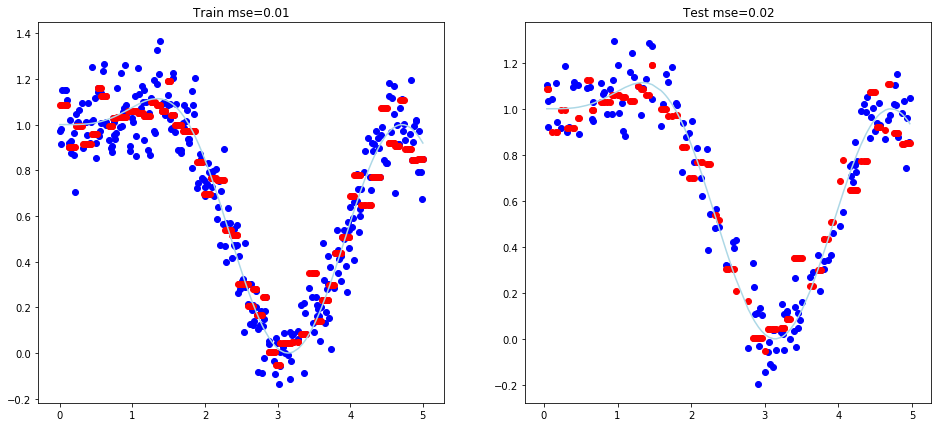

In [41]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
plt.scatter(train_data_2, train_labels_2, c='b')
plt.scatter(train_data_2, train_answers_r_2, c='r')
plt.plot(sorted(train_data_2), np.sin(np.array(sorted(train_data_2)))**2+np.exp(-np.array(sorted(train_data_2))**2), c='lightBlue')

plt.title(f'Train mse={train_accuracy_r_2:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.scatter(test_data_2, test_labels_2, c='b')
plt.scatter(test_data_2, answers_r_2, c='r')
plt.plot(sorted(test_data_2), np.sin(np.array(sorted(test_data_2)))**2+np.exp(-np.array(sorted(test_data_2))**2), c='lightBlue')

plt.title(f'Test mse={test_accuracy_r_2:.2f}')

plt.show()

**Вывод:** По первому графику сложно что-либо сказать: видно, что ошибка на тесте сильно больше(в 4 раза, это ведь много?), чем на обучающей выборке. Наверное, это говорит о переобучении. Дерево получилось глубиной всего 10, хотя мы его не ограничивали. Сработал базовый критерий 1, который смотрит на прирост информации.<br>
По второму графику выборка больше, чем в первом случае, дерево получилось глубиной 57. Предсказывает довольно точно, ошибки маленькие и разница между обучающей и тестовой выборкой всего(?) в 2 раза. Видно, как для некоторых групп объектов предсказания "схлопнулись" вместе в одну линию. То есть результат получился более смазанным, чем исходные данные. Наверное, это цена за отсутствие переобучения.